## Previsao de Embarque 
- Simples 
- Sem Serie Temporal
- Regressao Linear
- Random Forest
- Com Grid Search
- Bagging, Stacking e Boosting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression

import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display
from pprint import pprint
from math import sqrt

#from shutil import unpack_archive
#unpack_archive('./df_input.zip', './')

## Filtro de Onibus e definicoes de features/target

In [2]:
# Reading Data file (geolocalized)
data = pd.read_csv('./df_input.csv', sep=';', delimiter=';')

busline_filter = 41
data_model = data.copy()

#d_ano,  estao disponiveis para inserir once eu tive mais de 1 ano de dados
feature_names = [
    'hour_sin', 'hour_cos', 
    'd_mes', 'd_ano', 'mes', 'semana_do_mes', 
    'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
    'feriado', 'vespera_feriado']

target = 'validations_per_hour'

In [4]:
day_of_week_translator = {
    0: "Domingo",
    1: "Segunda",
    2: "Terca",
    3: "Quarta",
    4: "Quinta",
    5: "Sexta",
    6: "Sabado"
}

feriados = [
            ['Ano Novo', 1, 1],
            ['Carnaval', 24, 2],
            ['Carnaval', 25, 2],
            ['Carnaval', 26, 2],
            ['Dia de São José', 19, 3],
            ['Data Magna', 25, 3],
            ['Sexta-Feira Santa', 10, 4],
            ['Aniversário de Fortaleza', 13, 4],
            ['Tiradentes', 21, 4],
            ['Dia do Trabalho', 1, 5],
            ['Corpus Christi', 28, 5],
            ['N. Senhora da Assunção', 27, 5],
            ['Independência do Brasil', 7, 9],
            ['N. Senhora de Aparecida', 12, 10],
            ['Dia de Finados', 2, 11],
            ['Proclamação da Republica', 15, 11],
            ['Natal', 25, 12],
]

vesperas = [
            ['Ano Novo', 31, 12],
            ['Carnaval', 23, 2],
            ['Dia de São José', 18, 3],
            ['Data Magna', 24, 3],
            ['Sexta-Feira Santa', 9, 4],
            ['Aniversário de Fortaleza', 12, 4],
            ['Tiradentes', 20, 4],
            ['Dia do Trabalho', 30, 4],
            ['N. Senhora da Assunção', 26, 5],
            ['Independência do Brasil', 6, 9],
            ['N. Senhora de Aparecida', 11, 10],
            ['Dia de Finados', 1, 11],
            ['Proclamação da Republica', 14, 11],
            ['Natal', 24, 12],
]

In [29]:
one_hot_encoder = OneHotEncoder(sparse=False)

data_model[['domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado']] = one_hot_encoder.fit_transform(data_model['d_semana'].values.reshape(-1,1))
data_model['feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in feriados) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]
data_model['vespera_feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in vesperas) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]

top100_linhas = data_model.linha.value_counts().index[:100]
top100_linhas_data_model = data_model[data_model.linha.isin(top100_linhas)].loc[data['mes'] != 1]
top100_linhas_data_model

line_data_model = data_model.loc[data['linha'] == busline_filter].loc[data['mes'] != 1].copy()

X = line_data_model.filter(feature_names, axis=1)
y = line_data_model.validations_per_hour

In [34]:
#top100_linhas_data_model.to_csv('./top100.csv', index=False)
top100_linhas_data_model

In [6]:
#display(X)

In [7]:
#display(y)

---------------------------------------------------------------------------- Fim Setup ----------------------------------------------------------------------------  
# Criacao dos Modelos

In [8]:
model_list = []

In [9]:
def get_performance(model):
    y_test_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_test_predict)
    rmse = (np.sqrt(mse))
    r2 = r2_score(Y_test, y_test_predict)
    mae = mean_absolute_error(Y_test, y_test_predict)
    #mape = mean_absolute_percentage_error(Y_test, y_test_predict)
    performance_scoring = [
        r2,
        rmse,
        mae,
        #mape
    ]
    #performance_scoring = pd.DataFrame(performance_scoring,columns=['Metrica', 'Score'])
    #performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
    return performance_scoring

### Grid Search

In [10]:
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()

#### Linear Regression Model Parameters

In [11]:
print("Linear Regression  Params ----> ")
pprint(LinearRegressionModel.get_params())

copy_X = [True, False]
fit_intercept = [True, False]
n_jobs = [2, 4, 6, 8]
normalize = [True, False]


# Create the random grid
random_grid_linearregression = {'copy_X': copy_X, 'fit_intercept': fit_intercept, 'n_jobs': n_jobs, 'normalize': normalize}

print("Random Grid - LINEAR REGRESSION")
pprint(random_grid_linearregression)

Linear Regression  Params ----> 
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
Random Grid - LINEAR REGRESSION
{'copy_X': [True, False],
 'fit_intercept': [True, False],
 'n_jobs': [2, 4, 6, 8],
 'normalize': [True, False]}


#### Random Forest Model Parameters

In [12]:
print("Random Forest Model Params ----> ")
pprint(RandomForestModel.get_params())

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 1000, num = 10)]

n_jobs = [2, 4, 6, 8]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid_randomforest = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'n_jobs': n_jobs}

print("Random Grid - RANDOM FOREST")
pprint(random_grid_randomforest)

Random Forest Model Params ----> 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
Random Grid - RANDOM FOREST
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [20, 128, 237, 346, 455, 564, 673, 782, 891, 1000],
 'n_jobs': [2, 4, 6, 8]}


In [13]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()
gridsearch_result_randomforest = RandomizedSearchCV(estimator = RandomForestModel, param_distributions = random_grid_randomforest, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
gridsearch_result_linearregression = RandomizedSearchCV(estimator = LinearRegressionModel, param_distributions = random_grid_linearregression, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

gridsearch_result_randomforest.fit(X_train, Y_train)
gridsearch_result_linearregression.fit(X_train, Y_train)

print("Random Forest Best Parameters -----> ")
pprint(gridsearch_result_randomforest.best_params_)

print("Linear Regression Best Parameters -----> ")
pprint(gridsearch_result_linearregression.best_params_)

gridsearched_random_randomforest = gridsearch_result_randomforest.best_estimator_
gridsearch_random_linearregression = gridsearch_result_linearregression.best_estimator_

default_linearregression_model = LinearRegressionModel.fit(X_train, Y_train)
default_randomforest_model = RandomForestModel.fit(X_train, Y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Random Forest Best Parameters -----> 
{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 237,
 'n_jobs': 2}
Linear Regression Best Parameters -----> 
{'copy_X': True, 'fit_intercept': False, 'n_jobs': 2, 'normalize': True}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.2s
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.5min finished
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_search.py:277: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    0.9s finished


In [14]:
sample = X.sample(n=1)
sample

,hour_sin,hour_cos,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
988552,-0.398401,-0.917211,30,274,9,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0


In [15]:
print("###  1 Modelo Por Linha (dado completo de treino)")

performance_default_linearregression_model = get_performance(default_linearregression_model)
performance_default_randomforest_model = get_performance(default_randomforest_model)
performance_gridsearched_linearregression_model = get_performance(gridsearch_random_linearregression)
performance_gridsearched_randomforest_model = get_performance(gridsearched_random_randomforest)

print("\n----------------------------------------------------\n")
print('Regressao Linear [DEFAULT]: \n', performance_default_linearregression_model)
print("\n----------------------------------------------------\n")
print('Random Forest [DEFAULT]: \n', performance_default_randomforest_model)
print("\n----------------------------------------------------\n")
print('Regressao Linear [GRID SEARCH]: \n', performance_gridsearched_linearregression_model)
print("\n----------------------------------------------------\n")
print('Random Forest [GRID SEARCH]: \n', performance_gridsearched_randomforest_model)
print("\n----------------------------------------------------\n")

print("\nUtilizando sample aleatorio de dado para teste de previsao: ")

predict_res = default_linearregression_model.predict(sample)

print("Regressao Linear -> resultado do predict de test: ", predict_res)

predict_res2 = default_randomforest_model.predict(sample)
print("Random Forest -> resultado do predict de test: ", predict_res2)

random_res = gridsearch_random_linearregression.predict(sample)
print("Regressao Linear Best Grid Searched -> resultado do predict de test: ", predict_res2)

random_res = gridsearched_random_randomforest.predict(sample)
print("Random Forest Best Grid Searched -> resultado do predict de test: ", predict_res2)

display(data_model.loc[sample.index[0]:sample.index[0]])

print('LINHA UTILIZADA PARA OS TESTES: ', busline_filter)

performance_total = [performance_default_linearregression_model,
    performance_default_randomforest_model,
    performance_gridsearched_linearregression_model,
    performance_gridsearched_randomforest_model]

performance_total = pd.DataFrame.from_records(performance_total, columns=['R2', 'RMSE', 'MAE'], 
    index=['LinearReg Default', 'RandomForest Default', 'LinearReg GridSearched', 'RandomForest GridSearched'])
performance_total

###  1 Modelo Por Linha (dado completo de treino)

----------------------------------------------------

Regressao Linear [DEFAULT]: 
 [0.38108258495687986, 212.46178497824638, 158.53020063087848]

----------------------------------------------------

Random Forest [DEFAULT]: 
 [0.9764906381747931, 41.40806099698248, 29.89730762161815]

----------------------------------------------------

Regressao Linear [GRID SEARCH]: 
 [0.3810825849568801, 212.46178497824636, 158.53020063087783]

----------------------------------------------------

Random Forest [GRID SEARCH]: 
 [0.9770358053975098, 40.925131503206515, 29.584536267640864]

----------------------------------------------------


Utilizando sample aleatorio de dado para teste de previsao: 
Regressao Linear -> resultado do predict de test:  [539.37036208]
Random Forest -> resultado do predict de test:  [475.57]
Regressao Linear Best Grid Searched -> resultado do predict de test:  [475.57]
Random Forest Best Grid Searched -> resultado 

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
988552,41,2020-09-30 13:00:00,477,2,-0.398401,-0.917211,13,30,274,9,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0


LINHA UTILIZADA PARA OS TESTES:  41


,R2,RMSE,MAE
LinearReg Default,0.381083,212.461785,158.530201
RandomForest Default,0.976491,41.408061,29.897308
LinearReg GridSearched,0.381083,212.461785,158.530201
RandomForest GridSearched,0.977036,40.925132,29.584536


## BAGGING

In [16]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
warnings.filterwarnings("ignore") # To ignore warnings
n_jobs = -1 # This parameter conrols the parallel processing. -1 means using all processors.
random_state = 42 # This parameter controls the randomness of the data. Using some int value to get same results everytime this code is run
models_scores = [] # To store model scores               

def bagging_model(estimator):
    """
    I/P
    estimator: The base estimator from which the ensemble is grown.
    O/P
    br_y_pred: Predictions on test data for the base estimator.
    
    """
    regr = BaggingRegressor(base_estimator=estimator,
                            n_estimators=10,
                            max_samples=1.0,
                            bootstrap=True, # Samples are drawn with replacement
                            n_jobs= n_jobs,
                            random_state=random_state).fit(X_train, Y_train)

    br_y_pred = regr.predict(X_test)

    performance = get_performance(regr)
    
    print(f'Performance for base estimator {regr.base_estimator_} = {performance}\n')

    return regr, performance

LinearRegressionModelPipeline = make_pipeline(LinearRegression())
RandomForestModelPipeline = make_pipeline(RandomForestRegressor())

bagging_lr_model, performance_bagging_lr_model = bagging_model(LinearRegressionModelPipeline)
bagging_rf_model, performance_bagging_rf_model = bagging_model(RandomForestModelPipeline)

df2 = pd.DataFrame([performance_bagging_lr_model, performance_bagging_rf_model], columns=['R2','RMSE','MAE'], 
    index=['LinearRegression Bagging', 'RandomForest Bagging'])
performance_total = pd.concat([df2, performance_total])


Performance for base estimator Pipeline(memory=None,
         steps=[('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False) = [0.38046972703661563, 212.56694979259984, 158.72459287274364]

Performance for base estimator Pipeline(memory=None,
         steps=[('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                 

# STACKING

In [17]:

estimators = [ ('random_forest', RandomForestModelPipeline), ('linear_reg', LinearRegressionModelPipeline)]

stack = StackingRegressor(estimators=estimators, final_estimator= RandomForestModelPipeline, cv= 5, n_jobs= n_jobs, passthrough = True)

stack.fit(X_train, Y_train)

performance = get_performance(stack)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE'], 
    index=['Stacking Regressors'])

performance_total = pd.concat([df2, performance_total])


# BOOSTING

In [18]:
gradient_boosting_regressor= GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = random_state)

gradient_boosting_regressor.fit(X_train, Y_train)

performance = get_performance(gradient_boosting_regressor)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE'], 
    index=['GradientBoostingRegressor'])

performance_total = pd.concat([df2, performance_total])


In [19]:
print('PERFORMANCE DOS MODELOS PARA A LINHA: ', busline_filter)
performance_total.sort_values('R2', ascending=False)

PERFORMANCE DOS MODELOS PARA A LINHA:  41


,R2,RMSE,MAE
RandomForest GridSearched,0.977036,40.925132,29.584536
RandomForest Default,0.976491,41.408061,29.897308
Stacking Regressors,0.976352,41.529853,29.713498
RandomForest Bagging,0.976057,41.788090,29.900033
GradientBoostingRegressor,0.973293,44.134100,31.719544
LinearReg GridSearched,0.381083,212.461785,158.530201
LinearReg Default,0.381083,212.461785,158.530201
LinearRegression Bagging,0.380470,212.566950,158.724593


### Todos os modelos treinados dentro de *model_list*

In [20]:
model_list = [
    default_linearregression_model,
    default_randomforest_model,
    gridsearch_result_linearregression,
    gridsearch_result_randomforest,
    bagging_lr_model,
    bagging_rf_model,
    stack,
    gradient_boosting_regressor
]

### Treinar com (N-Y) meses, Prever mes (N)

In [21]:
#X_train, Y_train
#X_test, Y_test
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
# X = line_data_model.filter(feature_names, axis=1)
# y = line_data_model.validations_per_hour

#quantos meses (comecando do final do dado) vou prever
horizonte_de_previsao = 1
meses = line_data_model.mes.sort_values().unique()
horizonte_de_treinamento = meses[:meses.size - horizonte_de_previsao]
meses_de_previsao = meses[meses.size - horizonte_de_previsao:] 
print(horizonte_de_treinamento)
print(meses_de_previsao)
df_treinamento = line_data_model[line_data_model.mes.isin(horizonte_de_treinamento)].copy()
df_previsao = line_data_model[line_data_model.mes.isin(meses_de_previsao)].copy()
df_prev = df_previsao.filter(feature_names, axis = 1)
df_results = df_previsao.filter('validations_per_hour', axis = 1)

X = df_treinamento.filter(feature_names, axis=1)
y = df_treinamento.validations_per_hour
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)


print(busline_filter)
# print(df_treinamento)
print(df_previsao.head())

# model_list = [
#     default_linearregression_model,
#     default_randomforest_model,
#     gridsearch_result_linearregression,
#     gridsearch_result_randomforest,
#     bagging_lr_model,
#     bagging_rf_model,
#     stack,
#     gradient_boosting_regressor
# ]

predictions = [[],[],[],[],[],[],[],[]]
performances = [[],[],[],[],[],[],[],[]]

for i, model in enumerate(model_list):
    model.fit(X_train, Y_train)
    performances[i].append(get_performance(model))

    for index, row in df_prev.iterrows():
        predictions[i].append(model.predict([row])[0])

print(predictions[0])


[ 3  4  5  6  7  8  9 10 11]
[12]
41
         linha            data_hora  validations_per_hour  d_semana  hour_sin  \
1270969     41  2020-12-01 00:00:00                     9         1  0.000000   
1276203     41  2020-12-01 04:00:00                    55         1  0.887885   
1276204     41  2020-12-01 05:00:00                   501         1  0.979084   
1276205     41  2020-12-01 06:00:00                   935         1  0.997669   
1276206     41  2020-12-01 07:00:00                  1030         1  0.942261   

         hour_cos  hora  d_mes  d_ano  mes  semana_do_mes  domingo  segunda  \
1270969  1.000000     0      1    336   12              0      0.0      1.0   
1276203  0.460065     4      1    336   12              0      0.0      1.0   
1276204  0.203456     5      1    336   12              0      0.0      1.0   
1276205 -0.068242     6      1    336   12              0      0.0      1.0   
1276206 -0.334880     7      1    336   12              0      0.0      1.0   

 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.9min finished


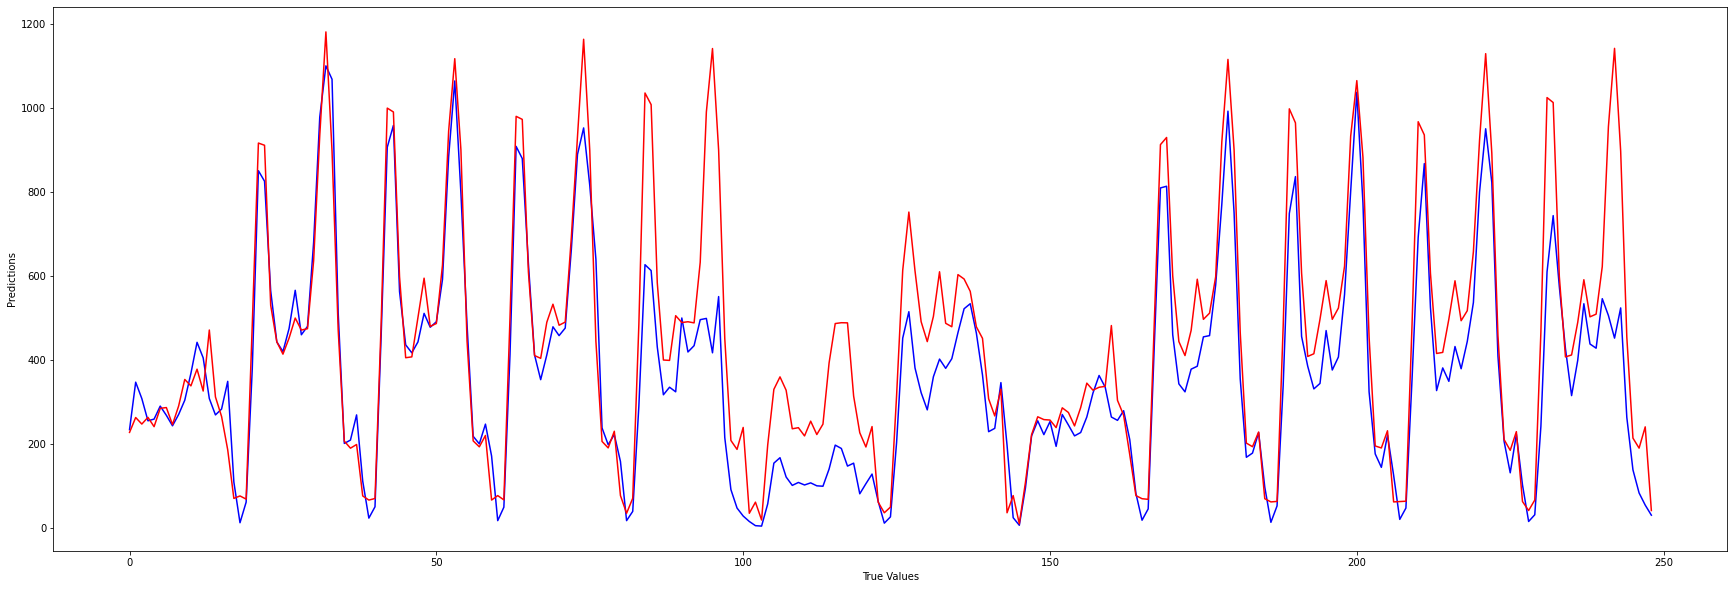

In [22]:
df_results = df_previsao.validations_per_hour

plt.figure(figsize=(30, 10))
plt.plot(range(len(df_results) - 360), df_results[360:], color='blue')
plt.plot(range(len(predictions[2]) - 360 ), predictions[6][360:], color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [23]:
performances

[[[0.3402516714526712, 206.53696111633892, 156.16409052662618]],
 [[0.9742687025346599, 40.78866358443349, 29.52013194711847]],
 [[0.3402516714526712, 206.53696111633892, 156.16409052662618]],
 [[0.9748103747818954, 40.357056831066615, 29.275709905276763]],
 [[0.33978281098305163, 206.61033744320397, 156.07879345950028]],
 [[0.9743009803356733, 40.763072540890896, 29.33468111635295]],
 [[0.9747583337113785, 40.39872360438851, 28.873849848115345]],
 [[0.9729962077397567, 41.785058312766395, 30.861473457983486]]]

In [24]:
df = pd.DataFrame(predictions)
df.to_csv('predictions0.csv', index=False)

In [25]:
# ACCESS IN ORDER PREDICTION VALUES
df.iloc[0]

0      350.022166
1      377.562491
2      409.851282
3      448.564941
4      490.832254
          ...    
604    413.369604
605    371.668484
606    334.235128
607    303.845797
608    282.754329
Name: 0, Length: 609, dtype: float64

In [26]:
# #top 100 exampled linhas
# #data_model.linha.value_counts().index[:100]

# print(data_model.linha.value_counts().index[:100])

d_31 = [1, 3, 5, 7, 8, 10, 12]
d_30 = [4, 6, 9, 11]

from datetime import datetime
import datetime
import calendar

def week_of_month(tgtdate):
    tgtdate = tgtdate.to_pydatetime()
    startdate = 0

    days_this_month = calendar.mdays[tgtdate.month]
    for i in range(1, days_this_month):
        d = datetime.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break
    # now we canuse the modulo 7 appraoch
    return (tgtdate - startdate).days //7 + 1

# #ate outubro para prever novembro
# for linha in top100_linhas:
#     #linha filter
#     currentLinhaData = data_model[data_model.linha == linha]
#     print(currentLinhaData)
#     for mes in range(3, 12):
#         currentLinhaData = currentLinhaData[currentLinhaData.mes == mes]

#         if mes in d_31:
#             d_d = 31
#         elif mes in d_30:
#             d_d = 30
#         else:
#             d_d = 29
        
#         for dia in range(1, d_d):
#             currentLinhaData = currentLinhaData[currentLinhaData.d_mes == dia]
#             for hora in range(24):
#                 currentLinhaData = currentLinhaData[currentLinhaData.hora == hora]
#                 if currentLinhaData.empty:
#                     # feature_names = [
#                     # 'hour_sin', 'hour_cos', 
#                     # 'd_mes', 'mes', 'semana_do_mes', 
#                     # 'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
#                     # 'feriado', 'vespera_feriado']
#                     # target = 'validations_per_hour'

#                     # a_row = pd.Series([1, 2])
#                     # df = pd.DataFrame([[3, 4], [5, 6]])
#                     # row_df = pd.DataFrame([a_row])
#                     # df = pd.concat([row_df, df], ignore_index=True)

#                     h_sin = np.sin(2 * np.pi * hora/23.0)
#                     h_cos = np.cos(2 * np.pi * hora/23.0)
#                     semana_do_mes = (dia-1) // 7 + 1
#                     #dia do ano
#                     ins = pd.Series([linha, data_hora, 0, h_sin, h_cos, dia, mes, semana_do_mes *DIASDASEMANAENCODED, *feriado, *vesperaferiado])
#                     ins_df = pd.DataFrame([ins])

#                     currentLinhaData = pd.concat([ins_df, currentLinhaData], ignore_index=True)
#                     print(f"INSERINDO MISSING HORA {hora} no dia {dia} do mes {mes}")

# t = data_model[data_model.linha.isin(data_model.linha.value_counts().index[:100])]
# t

         linha            data_hora  validations_per_hour  d_semana  \
19          10  2020-03-01 00:00:00                    15         6   
20          10  2020-03-01 01:00:00                    10         6   
21          10  2020-03-01 02:00:00                     6         6   
22          10  2020-03-01 03:00:00                    16         6   
23          10  2020-03-01 04:00:00                    54         6   
...        ...                  ...                   ...       ...   
1415831     10  2020-12-31 19:00:00                   223         3   
1415832     10  2020-12-31 20:00:00                   139         3   
1415833     10  2020-12-31 21:00:00                   157         3   
1415834     10  2020-12-31 22:00:00                   105         3   
1415835     10  2020-12-31 23:00:00                    17         3   

             hour_sin  hour_cos  hora  d_mes  d_ano  mes  semana_do_mes  \
19       0.000000e+00  1.000000     0      1     61    3              0 

NameError: name 'data_hora' is not defined

## Ranking Linhas de Onibus

In [ ]:

# print(data_model.linha.value_counts(ascending=True)[data_model['linha'].value_counts() < 100])

# linha_lista = data_model.linha.unique()
# linha_lista = linha_lista[:10]
# res_map = list()
# for linha in linha_lista:
#     for model in model_list:
#         currentLinhaData = data_model.loc[data['linha'] == linha].copy()
#         if len(currentLinhaData) < 10:
#             continue
#         X = currentLinhaData.filter(['hour_sin', 'hour_cos', 
#         'd_mes', 'd_ano', 'mes', 'semana_do_mes', 
#         'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
#         'feriado', 'vespera_feriado'], axis=1)
#         y = currentLinhaData.validations_per_hour

#         #FAZER TODOS OS MODELOS PARA AS LINHAS E ADICIONAR NA TABELA PRINCIPAL
#         #RANDOM FOREST COM GRID SEARCH
#         #LINEAR REGRESSION COM GRID SEARCH
#         #BAGGING STACKING AND BOOSTING
#         #
#         model.fit(X_train, Y_train)
#         performance = get_performance(model)
#         performance.insert(0, linha)
#         res_map.append(performance)

# res_map = pd.DataFrame(res_map,columns=['Linha', '[LR][DEF]R2', '[LR][DF]RMSE', '[LR][DF]MAE',
#     '[RF][GS]R2', '[RF][GS]RMSE', '[RF][GS]MAE',
#     '[LR][BAG]R2', '[LR][BAG]RMSE', '[LR][BAG]MAE',
#     '[RF][BAG]R2', '[RF][BAG]RMSE', '[RF][BAG]MAE',
#     '[STK]R2', '[STK]RMSE', '[STK]MAE',
#     '[BOS]R2', '[BOS]RMSE', '[BOS]MAE' ])

# #performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
# res_map = res_map.sort_values('R2').reset_index(drop=True)
# res_map

## Avaliacao dos dados atualmente
404 linhas  
358 com pelo menos 10 exemplos



In [ ]:
# res_map.to_csv('./classic-linha-comp.csv', index = False)